In [ ]:
!unzip -q dev
!unzip -q test
!unzip -q train

!cp -r dev/* test/ && rm -r dev
!cp -r test/* train/ && rm -r test 

## Analyse total available durations

In [ ]:
import os
import shutil
import librosa

### MG

In [46]:
from collections import Counter
import matplotlib.pyplot as plt

CORAL_samples_path = "/workspace/datasets/CORAA/train/CORAL"
dur_per_type = Counter()
dur_per_spkr = Counter()
total_dur_CORAL = 0

for filename in os.listdir(CORAL_samples_path):
    spkr_id = filename.split('_')[-1][:-4]
    recording_type = spkr_id[-4:-2]

    sample_path = os.path.join(CORAL_samples_path, filename)
    sample_dur = librosa.get_duration(path=sample_path)

    dur_per_type[recording_type] += sample_dur
    dur_per_spkr[spkr_id] += sample_dur
    total_dur_CORAL += sample_dur

mean_dur_per_spkr =  sum(dur_per_spkr.values()) / len(dur_per_spkr)
mean_dur_per_type = sum(dur_per_type.values()) / len(dur_per_type)
print(f"Total sample duration available in CORAL: {total_dur_CORAL/3600:.2f} hours\n"
      f"Mean sample duration per speaker: {mean_dur_per_spkr:.2f} seconds\n"
      f"Mean sample duration per recording type: {mean_dur_per_type/3600:.2f} hours\n"
      f"Total duration of monologue type: {dur_per_type['mn']/3600:.2f} hours")

Total sample duration available in CORAL: 9.63 hours
Mean sample duration per speaker: 251.33 seconds
Mean sample duration per recording type: 3.21 hours
Total duration of monologue type: 4.21 hours


### RE

In [50]:
NURC_RE_samples_path = "/workspace/datasets/CORAA/train/NURC_RE"
dur_per_type_RE = Counter()
dur_per_spkr_RE = Counter()
total_dur_NURC_RE = 0

for rec_type_folder in os.listdir(NURC_RE_samples_path):
    recording_type_RE = rec_type_folder.split('_')[-1]

    rec_type_path = os.path.join(NURC_RE_samples_path, rec_type_folder)

    for spkr_folder in os.listdir(rec_type_path):
        spkr_id_RE = spkr_folder
        audio_folder_path = os.path.join(rec_type_path, spkr_folder)

        for audio_file in os.listdir(audio_folder_path):
            sample_path = os.path.join(audio_folder_path, audio_file)
            sample_dur = librosa.get_duration(path=sample_path)

            dur_per_type_RE[recording_type_RE] += sample_dur
            dur_per_spkr_RE[spkr_id_RE] += sample_dur
            total_dur_NURC_RE += sample_dur

mean_dur_per_spkr_RE =  sum(dur_per_spkr_RE.values()) / len(dur_per_spkr_RE)
mean_dur_per_type_RE = sum(dur_per_type_RE.values()) / len(dur_per_type_RE)
print(f"Total sample duration available in NURC_RE: {total_dur_NURC_RE/3600:.2f} hours\n"
      f"Mean sample duration per speaker: {mean_dur_per_spkr_RE:.2f} seconds\n"
      f"Mean sample duration per recording type: {mean_dur_per_type_RE/3600:.2f} hours\n"
      f"Total duration of monologue type: {dur_per_type_RE['EF']/3600:.2f} hours")

Total sample duration available in NURC_RE: 141.31 hours
Mean sample duration per speaker: 1532.28 seconds
Mean sample duration per recording type: 47.10 hours
Total duration of monologue type: 12.92 hours


Text(0.725, 0.02, 'Duration (minutes)')

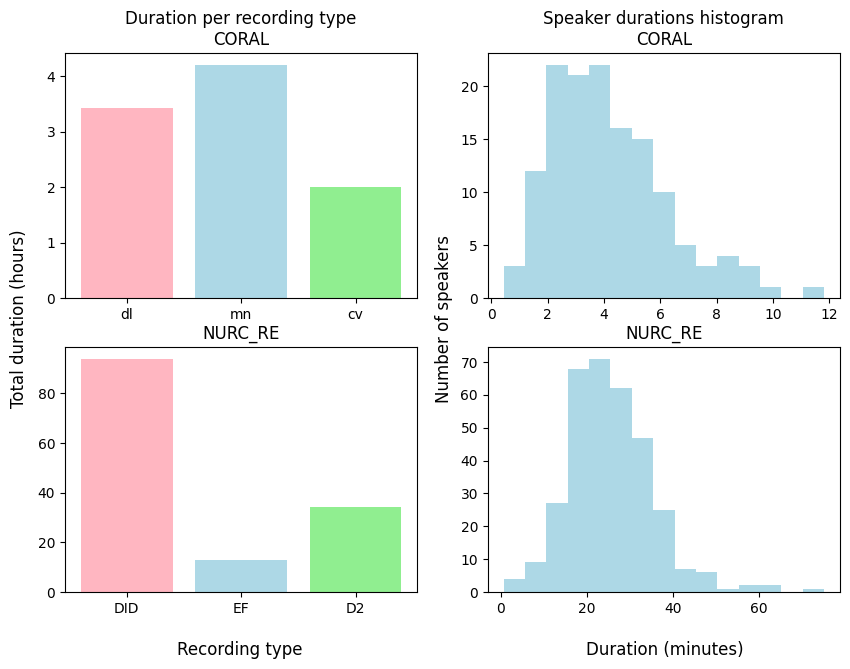

In [61]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 7))

type_keys = list(dur_per_type.keys())
type_values = [i/3600 for i in list(dur_per_type.values())]

type_keys_RE = list(dur_per_type_RE.keys())
type_values_RE = [i/3600 for i in list(dur_per_type_RE.values())]

spkr_keys = list(dur_per_spkr.keys())
spkr_values = [i/60 for i in list(dur_per_spkr.values())]

spkr_keys_RE = list(dur_per_spkr_RE.keys())
spkr_values_RE = [i/60 for i in list(dur_per_spkr_RE.values())]

axes[0, 0].bar(type_keys, type_values, color = ['lightpink', 'lightblue', 'lightgreen'], label = 'MG')
axes[0, 0].set_title('Duration per recording type\nCORAL')

axes[0, 1].hist(spkr_values, color='lightblue', bins=15)
axes[0, 1].set_title('Speaker durations histogram\nCORAL')

axes[1, 0].bar(type_keys_RE, type_values_RE, color = ['lightpink', 'lightblue', 'lightgreen'], label = 'RE')
axes[1, 0].set_title('\nNURC_RE')

axes[1, 1].hist(spkr_values_RE, color='lightblue', bins=15)
axes[1, 1].set_title('\nNURC_RE')

fig.text(0.07, 0.5, 'Total duration (hours)', va='center', rotation='vertical', fontsize=12)
fig.text(0.495, 0.5, 'Number of speakers', va='center', rotation='vertical', fontsize=12)

fig.text(0.3, 0.02, 'Recording type', ha='center', fontsize=12)
fig.text(0.725, 0.02, 'Duration (minutes)', ha='center', fontsize=12)



# Estruturar datasets

Iremos trabalhar apenas com o subconjunto de elocuções formais do NURC Recife e monólogos do C-ORAL Brasil. As manipulações de aquivos que seguem são realizadas a fim de estruturar o dataset no formato requerido pelo ```formatter``` VCTK_old, disponível no Coqui:

```
root_path/
├── txt/                      # Folder containing transcription files
│   ├── p225/                 # Speaker-specific folder
│   │   ├── p225_001.txt      
│   │   ├── p225_002.txt      
│   │   └── ...               
│   └── ...                   
├── wav48/                    # Folder containing audio files
│   ├── p225/                 
│   │   ├── p225_001.wav      
│   │   ├── p225_002.wav      
│   │   └── ...               
│   └── ...
```

## Filtrar amostras a partir de metadados
* A planilha de metadados do CORAA tem anotações que indicam ocorrência de fenômenos como hesitação, pausa preenchida e presença de segunda voz. Explicação das anotações em https://github.com/nilc-nlp/CORAA

In [2]:
import pandas as pd

metadata_test = pd.read_csv('/workspace/datasets/CORAA/metadata_test_final.csv')
metadata_dev = pd.read_csv('/workspace/datasets/CORAA/metadata_dev_final.csv')
metadata_train = pd.read_csv('/workspace/datasets/CORAA/metadata_train_final.csv')

metadata = pd.concat([metadata_test, metadata_dev, metadata_train], ignore_index = True)
metadata['file_path'] = metadata['file_path'].str.replace('test/', 'train/')
metadata['file_path'] = metadata['file_path'].str.replace('dev/', 'train/')

In [2]:
metadata_filtered = metadata[(metadata['down_votes'] == 0) &
                             (metadata['votes_for_filled_pause'] == 0) &
                             #(metadata['votes_for_second_voice'] == 0) &
                             (metadata['votes_for_hesitation'] == 0)]
                             #(metadata['votes_for_no_identified_problem'] >= 1)
                             #(metadata['votes_for_noise_or_low_voice'] == 0)

* Fazer uma filtragem muito rigorosa pode diminuir exageradamente o número de amostras. Isso pode ser alvo de experimentação a fim de avaliar se é melhor usar:
1. menos amostras com maior qualidade
2. mais amostras com qualidade reduzida

In [3]:
import re
#selected_samples = pd.read_csv('Seleção de dados.csv')

metadata_RE_02 = metadata_filtered[metadata_filtered['file_path'].str.contains(r"RE_EF")]
#metadata_RE = metadata_RE[metadata_RE['file_path'].str.split('/').str[-2].isin(selected_samples['speaker_id'])]

metadata_MG_02 = metadata_filtered[metadata_filtered['file_path'].str.contains(r"bfammn|bpubmn|bfamdl|bpubdl")]
#metadata_MG = metadata_MG[metadata_MG['file_path'].str.split('_').str[-1].str[:-4].isin(selected_samples['speaker_id'])]

# Arrange files

In [19]:
!mkdir dataset_RE_02
!mkdir dataset_RE_02/wav48
!mkdir dataset_RE_02/txt

!mkdir dataset_MG_02
!mkdir dataset_MG_02/wav48
!mkdir dataset_MG_02/txt

## RE

In [20]:
durations_RE = []

for _, row in metadata_RE_02.iterrows():
  audio_original_path = row['file_path']
  spkr_id, audio_filename = row['file_path'].split('/')[-2:]

  duration = librosa.get_duration(path=audio_original_path)

  if duration > 1.5 and duration < 10:
    durations_RE.append(duration)

    destination_path_audio = os.path.join("dataset_RE_02", "wav48", spkr_id)
    destination_path_txt = os.path.join("dataset_RE_02", "txt", spkr_id)

    os.makedirs(destination_path_audio, exist_ok=True)
    os.makedirs(destination_path_txt, exist_ok=True)

    shutil.copy(audio_original_path, os.path.join(destination_path_audio, audio_filename))

    text = row['text']
    txt_file_path = os.path.join(destination_path_txt, audio_filename[:-4] + '.txt')
    with open(txt_file_path, 'w') as file:
      file.write(text)

  else:
    continue

## MG

In [21]:
durations_MG = []

for _, row in metadata_MG_02.iterrows():
  audio_original_path = row['file_path']
  spkr_id = row['file_path'].split('_')[-1][:-4]
  audio_filename = row['file_path'].split('/')[-1]

  duration = librosa.get_duration(path=audio_original_path)

  if duration > 1.5 and duration < 10:
    durations_MG.append(duration)

    destination_path_audio = os.path.join("dataset_MG_02", "wav48", spkr_id)
    destination_path_txt = os.path.join("dataset_MG_02", "txt", spkr_id)

    os.makedirs(destination_path_audio, exist_ok=True)
    os.makedirs(destination_path_txt, exist_ok=True)

    shutil.copy(audio_original_path, os.path.join(destination_path_audio, audio_filename))

    text = row['text']
    txt_file_path = os.path.join(destination_path_txt, audio_filename[:-4] + '.txt')
    with open(txt_file_path, 'w') as file:
      file.write(text)

  else:
    continue

# Current dataset durations

In [22]:
num_speakers_MG = len(os.listdir('dataset_MG_02/wav48'))
num_speakers_RE = len(os.listdir('dataset_RE_02/wav48'))

In [23]:
import numpy as np

total_dur_RE = np.sum(durations_RE)/3600
total_dur_MG = np.sum(durations_MG)/3600

print(f"Duração total de amostras da variedade RE: {total_dur_RE:.2f} horas\n"
f"Duração total de amostras da variedade MG: {total_dur_MG:.2f} horas\n\n"
f"Número total de falantes da variedade RE: {num_speakers_RE}\n"
f"Número total de falantes da variedade MG: {num_speakers_MG}")

Duração total de amostras da variedade RE: 9.95 horas
Duração total de amostras da variedade MG: 3.30 horas

Número total de falantes da variedade RE: 36
Número total de falantes da variedade MG: 95
